In [57]:
import numpy as np
import os
import matplotlib.pyplot as plt
from pymser import pymser
import signac

In [ ]:
def check_equil_converge(job, eq_data_dict, prod_tol):
    equil_matrix = []
    res_matrix = []
    prop_cols = [5]
    prop_names = ["Number of Moles"]
    try:
        # Load data for both boxes
        for key in list(eq_data_dict.keys()):
            eq_col = eq_data_dict[key]["data"]
        # df_box1 = np.genfromtxt(job.fn("gemc.eq.out.box1.prp"))
        # df_box2 = np.genfromtxt(job.fn("gemc.eq.out.box2.prp"))

        # Process both boxes in one loop
        # for box in [df_box1, df_box2]:
            # for prop_index in prop_cols:
            #     eq_col = box[:, prop_index - 1]
            # print(len(eq_col))
            batch_size = max(1, int(len(eq_col) * 0.0005))

            # Try with ADF test enabled, fallback without it if it fails
            try:
                results = pymser.equilibrate(eq_col, LLM=False, batch_size=batch_size, ADF_test=True, uncertainty='uSD', print_results=False)
                adf_test_failed = results["critical_values"]["1%"] <= results["adf"]
            except:
                results = pymser.equilibrate(eq_col, LLM=False, batch_size=batch_size, ADF_test=False, uncertainty='uSD', print_results=False)
                results["adf"], results["critical_values"], adf_test_failed = None, None, False

            equilibrium = len(eq_col) - results['t0'] >= prod_tol
            equil_matrix.append(equilibrium and not adf_test_failed)
            res_matrix.append(results)

        # Log results
        # print("ID", job.id, "AT", job.sp.atom_type, "T", job.sp.T)
        # print(equil_matrix)
        # log_text = '==============================================================================\n'
        
        for i, is_equilibrated in enumerate(equil_matrix):
            # box = df_box1 if i < len(prop_cols) else df_box2
            # box_name = "Liquid" if i < len(prop_cols) else "Vapor"
            # col_vals = box[:, prop_cols[i % len(prop_cols)] - 1]
            key_name = list(eq_data_dict.keys())[i]
            box_name = key_name.rsplit("_", 1)[0]
            col_vals = eq_data_dict[key_name]["data"]
            #plot all

            # if not all(equil_matrix):
            plot_res_pymser(job, col_vals, res_matrix[i], prop_names[i % len(prop_cols)], box_name)

            # Display outcome
            prod_cycles = len(col_vals) - res_matrix[i]['t0']
            if is_equilibrated:
                #Plot successful equilibration
                adf, one_pct = res_matrix[i]['adf'], res_matrix[i]['critical_values']['1%']
                
                statement = f"       > Success! "
                statement += f"ADF value: {adf}, 99% confidence value: {one_pct}! "
            else:
                #Plot failed equilibration
                statement = f"       > {box_name} Box Failure! "
                if res_matrix[i]["adf"] is None:
                    # Note: ADF test failed to complete
                    statement += f"ADF test failed to complete! "
                elif res_matrix[i]['adf'] > res_matrix[i]['critical_values']['1%']:
                    adf, one_pct = res_matrix[i]['adf'], res_matrix[i]['critical_values']['1%']
                    statement += f"ADF value: {adf}, 99% confidence value: {one_pct}! "
                if len(col_vals) - res_matrix[i]['t0'] < prod_tol:
                   statement += f"Only {prod_cycles} production cycles found."
                
            print(statement)

    except Exception as e:
        #This will cause an error in the GEMC operation which lets us know that the job failed
        raise Exception(f"Error processing job {job.id}: {e}")

    return all(equil_matrix)

def plot_res_pymser(job, eq_col, results, name, box_name):
    fig, [ax1, ax2] = plt.subplots(1, 2, gridspec_kw={'width_ratios': [2, 1]}, sharey=True)

    ax1.set_ylabel(name + " " + box_name, color="black", fontsize=14, fontweight='bold')
    ax1.set_xlabel("GEMC Step", fontsize=14, fontweight='bold')

    ax1.plot(range(0, len(eq_col)*10, 10), 
            eq_col, 
            label = 'Raw data', 
            color='blue')

    ax1.plot(range(0, len(eq_col), 10)[results['t0']:], 
            results['equilibrated'], 
            label = 'Equilibrated data', 
            color='red')

    ax1.plot([0, len(eq_col)*10], 
            [results['average'], results['average']], 
            color='green', zorder=4, 
            label='Equilibrated average')

    ax1.fill_between(range(len(eq_col)), 
                    results['average'] - results['uncertainty'], 
                    results['average'] + results['uncertainty'], 
                    color='lightgreen', alpha=0.3, zorder=4)

    ax1.set_yticks(np.arange(0, eq_col.max()*1.1, eq_col.max()/10))
    ax1.set_xlim(-len(eq_col)*10*0.02, len(eq_col)*10*1.02)
    ax1.tick_params(axis="y", labelcolor="black")

    ax1.grid(alpha=0.3)
    ax1.legend()

    # bin_blue = int(len(eq_col)/results["ac_time"])
    ax2.hist(eq_col, 
            orientation=u'horizontal', 
            bins=30, 
            edgecolor='blue', 
            lw=1.5, 
            facecolor='white', 
            zorder=3)

    bin_red = 30
    ax2.hist(results['equilibrated'], 
            orientation=u'horizontal', 
            bins=bin_red, 
            edgecolor='red', 
            lw=1.5, 
            facecolor='white', 
            zorder=3)

    ymax = int(ax2.get_xlim()[-1])

    ax2.plot([0, ymax], 
            [results['average'], results['average']],
            color='green', zorder=4, label='Equilibrated average')

    ax2.fill_between(range(ymax), 
                    results['average'] - results['uncertainty'],
                    results['average'] + results['uncertainty'],
                    color='lightgreen', alpha=0.3, zorder=4)

    ax2.set_xlim(0, ymax)

    ax2.grid(alpha=0.5, zorder=1)

    fig.set_size_inches(9,5)
    fig.set_dpi(100)
    fig.tight_layout()
    save_name = 'MSER_eq_'+ box_name +'.png'
    # fig.savefig(job.fn(save_name), dpi=300, facecolor='white')
    plt.show()
    # plt.close(fig)

12e7c9c821c2e5b6888c3a179d793eeb 130.0
The results may not be reliable!
The results may not be reliable!


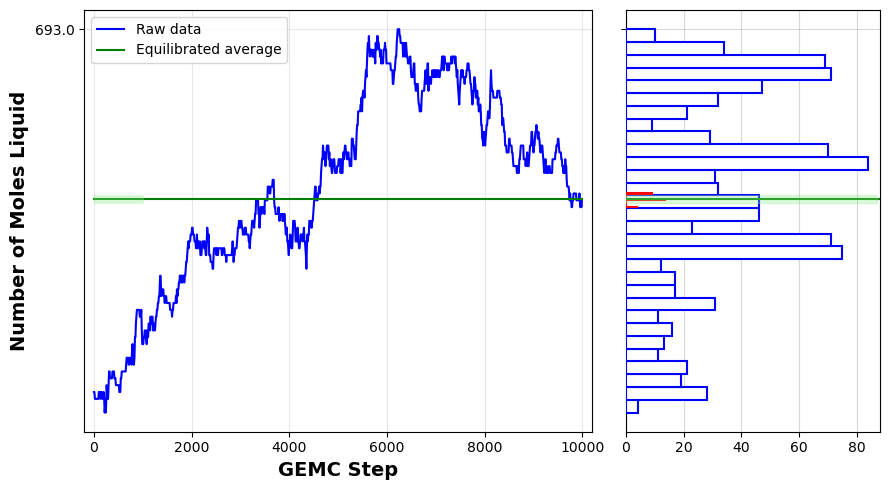

       > Liquid Box Failure! ADF value: -3.1843254850764344, 99% confidence value: -3.7112123008648155! Only 27 production cycles found.


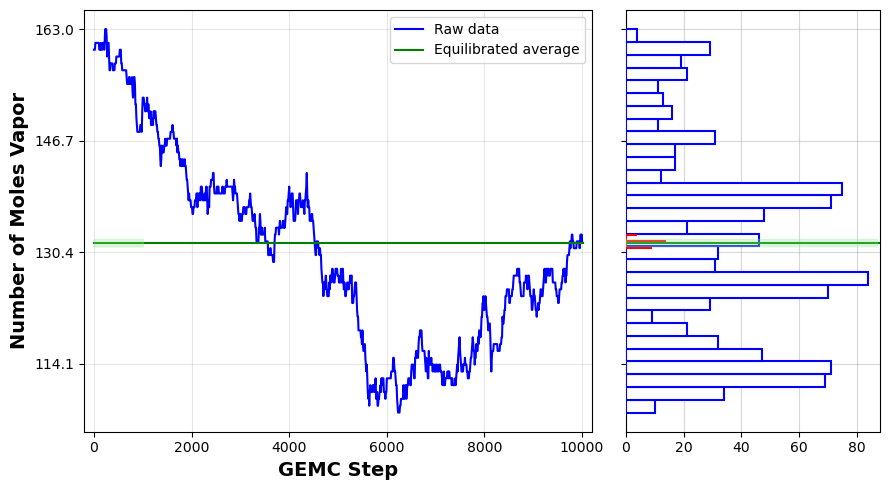

       > Vapor Box Failure! ADF value: -3.1843254850764673, 99% confidence value: -3.7112123008648155! Only 27 production cycles found.


In [78]:
project = signac.get_project("opt_ff_ms")
mol = "R50"
jobs = project.find_jobs({"mol_name": mol, "T":130, "atom_type":1 , "restart":1})
prop_cols = [5]
for job in jobs:
    print(job.id, job.sp.T)
    df_box1 = np.genfromtxt(job.fn("gemc.eq.out.box1.prp"))
    df_box2 = np.genfromtxt(job.fn("gemc.eq.out.box2.prp"))
    prod_tol = len(df_box1)/4
    eq_data_dict = {}
    for b, box in enumerate([df_box1, df_box2]):
        box_name = "Liquid" if b == 0 else "Vapor"
        for prop_index in prop_cols:
            eq_col = box[:, prop_index - 1]
            #Save eq_col as a csv for later analysis
            key = f"{box_name}_{prop_index}"
            eq_col_file = job.fn(f"{box_name}_eq_col_{prop_index}.csv")
            # np.savetxt(eq_col_file, eq_col, delimiter=",")
            #Save the eq_col and file to a dictionary for later use
            eq_data_dict[key] = {"data": eq_col, "file": eq_col_file}

    check_equil_converge(job, eq_data_dict, prod_tol)